In [2]:
import os
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
df1 = pd.read_csv('DATA/genomic-scale-with transcription and nuclear bodies.tsv', sep='\t')

print(df1.shape)

(7636776, 12)


In [4]:
print(df1.columns)
print(df1.head())

Index(['z(nm)', 'x(nm)', 'y(nm)', 'genomic coordinate', 'homolog number',
       'cell number', 'experiment number', 'gene names', 'transciption',
       'distance to lamina (nm)', 'distance to nucleoli (nm)',
       'distance to speckles (nm)'],
      dtype='object')
    z(nm)    x(nm)   y(nm)      genomic coordinate  homolog number  \
0  1058.0  62959.0  5936.0    chr1:2950000-3050000               1   
1  1260.0  61827.0  6129.0    chr1:5950000-6050000               1   
2  1928.0  65399.0  5633.0    chr1:8950000-9050000               1   
3  1075.0  63383.0  6607.0  chr1:11950000-12050000               1   
4     NaN      NaN     NaN  chr1:14950000-15050000               1   

   cell number  experiment number                       gene names  \
0         1788                  4                              NaN   
1         1788                  4  ENSG00000131697,ENSG00000069424   
2         1788                  4                  ENSG00000197241   
3         1788                

In [5]:
percent_nan = df1['transciption'].isna().mean() * 100
print(f"percentage of NaN in the transcription column: {percent_nan:.2f}%")


percentage of NaN in the transcription column: 41.59%


In [6]:
## filter out points with missing transcription data
df = df1.dropna(subset=['transciption'])
df = df[~df['transciption'].str.contains(',', na=False)] 

# fix typo in original dataset
df = df.rename(columns={'transciption': 'transcription'})

df[['chromosome', 'coordinate range']] = df['genomic coordinate'].str.split(':', expand=True)

# split coordinate range into coordinate start and coordinate end features
df[['coordinate start', 'coordinate end']] = df['coordinate range'].str.split('-', expand=True)
df['coordinate start'] = pd.to_numeric(df['coordinate start'])
df['coordinate end'] = pd.to_numeric(df['coordinate end'])
df = df.drop(columns=['coordinate range', 'genomic coordinate' ])


print(df.shape)
print(df.columns)


(2801722, 14)
Index(['z(nm)', 'x(nm)', 'y(nm)', 'homolog number', 'cell number',
       'experiment number', 'gene names', 'transcription',
       'distance to lamina (nm)', 'distance to nucleoli (nm)',
       'distance to speckles (nm)', 'chromosome', 'coordinate start',
       'coordinate end'],
      dtype='object')


In [7]:
print(df.head())

     z(nm)    x(nm)   y(nm)  homolog number  cell number  experiment number  \
2   1928.0  65399.0  5633.0               1         1788                  4   
12  1830.0  64779.0  4869.0               1         1788                  4   
15  1298.0  62042.0  6415.0               1         1788                  4   
17  1491.0  60940.0  4954.0               1         1788                  4   
20  1218.0  64056.0  6874.0               1         1788                  4   

         gene names transcription  distance to lamina (nm)  \
2   ENSG00000197241           off                     31.0   
12  ENSG00000174574           off                      0.0   
15  ENSG00000269113           off                    366.0   
17  ENSG00000203985           off                    515.0   
20  ENSG00000229537           off                    277.0   

    distance to nucleoli (nm)  distance to speckles (nm) chromosome  \
2                      3987.0                     1669.0       chr1   
12        

In [8]:
total_rows = df.shape[0]

on_count = df[df['transcription'] == 'on'].shape[0]
off_count = df[df['transcription'] == 'off'].shape[0]

on_fraction = on_count / total_rows
off_fraction = off_count / total_rows
print('fraction of transcription on and off genes')
print(on_fraction, off_fraction)

fraction of transcription on and off genes
0.13720204931110225 0.8627979506888978


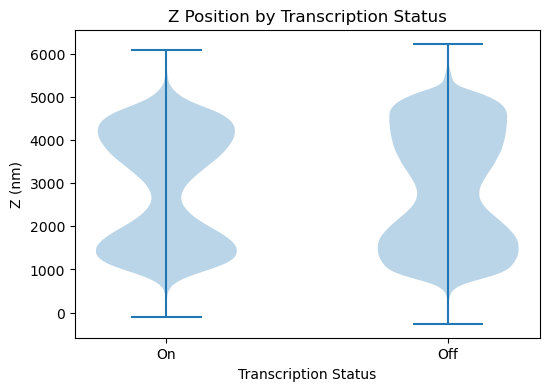

In [9]:
## EDA

# transcription is 'on' or 'off' (categorical) vs distance to the nuclear lamina (continuous)

dataset = [df[df['transcription']== 'on']['z(nm)'].values, 
           df[df['transcription']== 'off']['z(nm)'].values]

plt.figure(figsize=(6,4))
plt.xticks([1, 2], ['On', 'Off'])

plt.violinplot(dataset=dataset)
plt.xlabel('Transcription Status')
plt.ylabel('Z (nm)')
plt.title('Z Position by Transcription Status')

plt.savefig('violinplot_z_T.png', bbox_inches='tight')
plt.show()


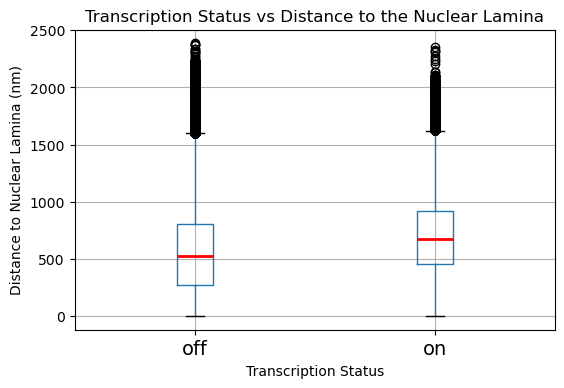

In [10]:
df[['distance to lamina (nm)', 'transcription']].boxplot(
    by='transcription', 
    figsize=(6, 4), 
    medianprops=dict(color='red', linewidth=2),  
)
plt.ylabel('Distance to Nuclear Lamina (nm)')
plt.xlabel('Transcription Status')
plt.xticks(fontsize=14)
plt.suptitle('')
plt.title('Transcription Status vs Distance to the Nuclear Lamina')

plt.savefig('dist_lamina.png', bbox_inches='tight')
plt.show()

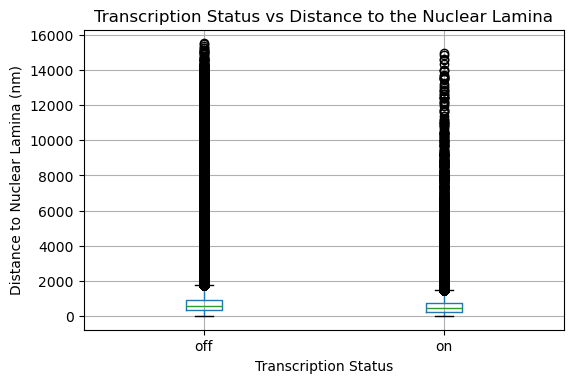

In [11]:
ax = df[['distance to speckles (nm)', 'transcription']].boxplot(by='transcription', figsize=(6, 4))
plt.ylabel('Distance to Nuclear Lamina (nm)')
plt.xlabel('Transcription Status')
plt.suptitle('')
plt.title('Transcription Status vs Distance to the Nuclear Lamina')
plt.show()

In [12]:
chr_order = ['chr1', 'chr2', 'chr3', 'chr4','chr5', 'chr6','chr7','chr8','chr9',
             'chr10','chr11','chr12','chr13','chr14','chr15','chr16','chr17', 'chr18',
             'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
count_matrix = df.groupby(['chromosome', 'transcription']).size().unstack()
print(count_matrix)

count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
# print(count_matrix_norm)

count_matrix_norm_ordered = count_matrix_norm.reindex(chr_order)
print(count_matrix_norm_ordered)

transcription     off     on
chromosome                  
chr1           221665  42310
chr10          106115  14010
chr11           89806  22204
chr12          100528   9035
chr13           64877   9348
chr14           78032   4575
chr15           82492   6183
chr16           41244  10637
chr17           79194  23108
chr18           81759   4810
chr19           52227  11308
chr2           192374  31857
chr20           83728  10154
chr21           73466   2891
chr22           50018  21538
chr3           167914  29261
chr4           138380  20371
chr5           115788  19332
chr6           130362   8337
chr7           107092  32675
chr8           139096  15511
chr9           125147  25392
chrX            96016   9555
transcription       off        on
chromosome                       
chr1           0.839720  0.160280
chr2           0.857928  0.142072
chr3           0.851599  0.148401
chr4           0.871680  0.128320
chr5           0.856927  0.143073
chr6           0.939891  0.060109
chr

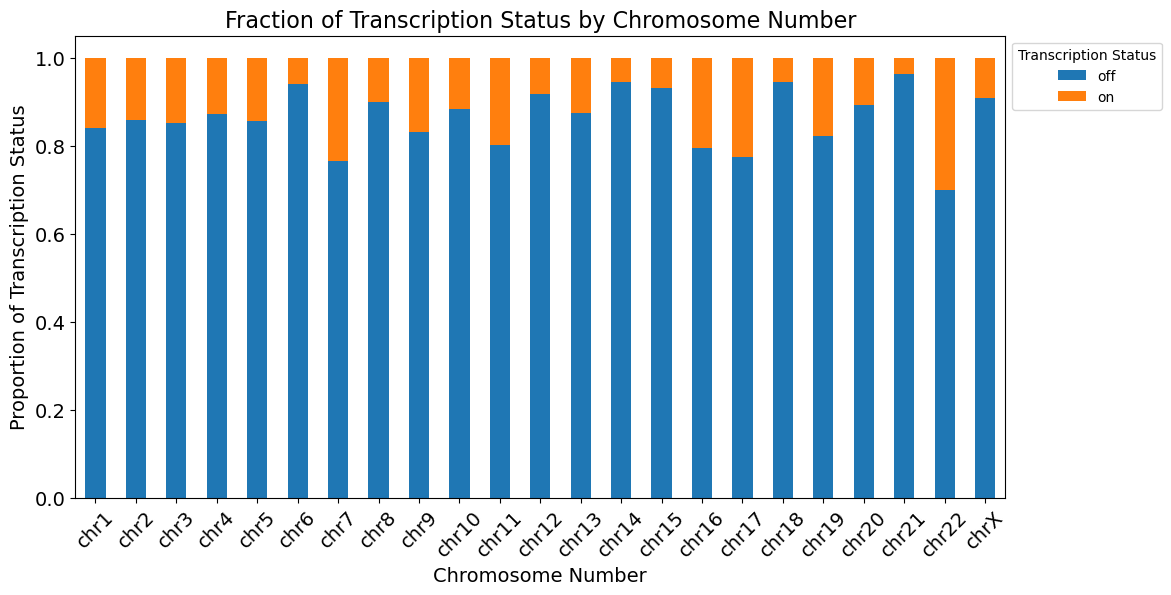

In [13]:
count_matrix_norm_ordered.plot(kind='bar', stacked=True,figsize=(12,6))
plt.ylabel('Proportion of Transcription Status', fontsize=14)
plt.xlabel("Chromosome Number", fontsize=14)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Fraction of Transcription Status by Chromosome Number', fontsize = 16)

plt.legend(title="Transcription Status", bbox_to_anchor=(1, 1))
plt.savefig('bychrnum.png', bbox_inches='tight')

plt.show()

In [23]:
## splitting

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import GroupShuffleSplit


y = df['transcription']
X = df.drop(columns=['transcription', 'cell number', 'experiment number'])
## cell number ID is unique between experiments
groups = df['cell number']

## split into train and other with 98% in train
gss = GroupShuffleSplit(n_splits=10, train_size=0.98, random_state=42)
train_idx, other_idx = next(gss.split(X, y, groups=groups))

X_train, X_other = X.iloc[train_idx], X.iloc[other_idx]
y_train, y_other = y.iloc[train_idx], y.iloc[other_idx]
groups_train, groups_other = groups.iloc[train_idx], groups.iloc[other_idx]

## split into test and val
gss_temp = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(gss_temp.split(X_other, y_other, groups=groups_other))

X_val, X_test = X_other.iloc[val_idx], X_other.iloc[test_idx]
y_val, y_test = y_other.iloc[val_idx], y_other.iloc[test_idx]
groups_val, groups_test = groups_other.iloc[val_idx], groups_other.iloc[test_idx]

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)
print("Test set size:", X_test.shape, y_test.shape)


Training set size: (2744991, 11) (2744991,)
Validation set size: (28375, 11) (28375,)
Test set size: (28356, 11) (28356,)


In [24]:
X_train

,z(nm),x(nm),y(nm),homolog number,gene names,distance to lamina (nm),distance to nucleoli (nm),distance to speckles (nm),chromosome,coordinate start,coordinate end
2,1928.0,65399.0,5633.0,1,ENSG00000197241,31.0,3987.0,1669.0,chr1,8950000,9050000
12,1830.0,64779.0,4869.0,1,ENSG00000174574,0.0,3789.0,1154.0,chr1,38950000,39050000
15,1298.0,62042.0,6415.0,1,ENSG00000269113,366.0,889.0,67.0,chr1,47950000,48050000
17,1491.0,60940.0,4954.0,1,ENSG00000203985,515.0,1496.0,897.0,chr1,53950000,54050000
20,1218.0,64056.0,6874.0,1,ENSG00000229537,277.0,2462.0,537.0,chr1,62950000,63050000
...,...,...,...,...,...,...,...,...,...,...,...
7636761,3692.0,167918.0,70778.0,2,ENSG00000077264,445.0,2624.0,476.0,chrX,110950000,111050000
7636762,3231.0,168829.0,70561.0,2,ENSG00000241743,131.0,1995.0,880.0,chrX,113950000,114050000
7636768,4602.0,166293.0,71362.0,2,ENSG00000134602,668.0,4161.0,663.0,chrX,131950000,132050000
7636771,3853.0,167571.0,71086.0,2,ENSG00000229269,563.0,3046.0,275.0,chrX,140950000,141050000


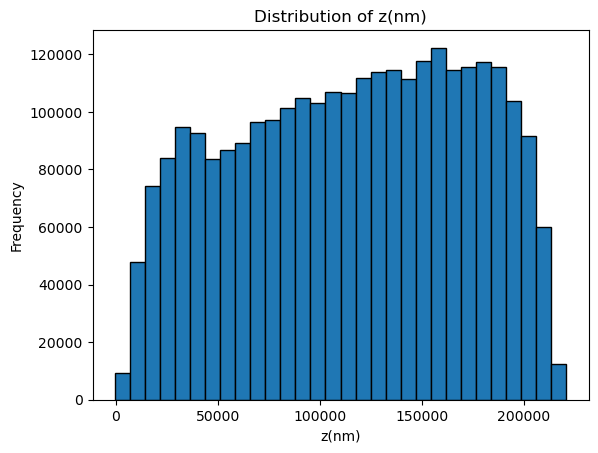

In [28]:
plt.hist(df['y(nm)'], bins=30, edgecolor='black')
plt.xlabel('z(nm)')
plt.ylabel('Frequency')
plt.title('Distribution of z(nm)')
plt.show()

In [30]:
## preprocessing

onehot_ftrs = ['chromosome','gene names','homolog number']
minmax_ftrs = ['x(nm)','y(nm)', 'z(nm)']
std_ftrs = ['distance to lamina (nm)','distance to nucleoli (nm)', 'distance to speckles (nm)','coordinate start','coordinate end']


preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('minmax', MinMaxScaler(), minmax_ftrs),
        ('std', StandardScaler(), std_ftrs)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])




In [31]:
X_train_prep = clf.fit_transform(X_train)
X_val_prep = clf.transform(X_val)
X_test_prep = clf.transform(X_test)


print(X_train.shape)
print(X_train_prep.shape)
print(X_train_prep)

(2744991, 11)
(2744991, 498)
[[ 1.          0.          0.         ...  1.94404722 -1.25414595
  -1.25414595]
 [ 1.          0.          0.         ...  0.97028778 -0.72988032
  -0.72988032]
 [ 1.          0.          0.         ... -1.08500643 -0.57260063
  -0.57260063]
 ...
 [ 0.          0.          0.         ...  0.04190742  0.89534312
   0.89534312]
 [ 0.          0.          0.         ... -0.69172106  1.05262281
   1.05262281]
 [ 0.          0.          0.         ... -0.34192398  1.26232906
   1.26232906]]


In [34]:
print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)
print("Test set size:", X_test.shape)


Training set size: (2744991, 11)
Validation set size: (28375, 11)
Test set size: (28356, 11)
